In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [0]:
from keras import backend as K
K.clear_session()

# Generating images

## Variational autoencoders

![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

In [0]:
# Encode the input into a mean and variance parameter
z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
reconstructed_img = decoder(z)

# Instantiate a model
model = Model(input_img, reconstructed_img)

# Then train the model using 2 losses:
# a reconstruction loss and a regularization loss

Here is the encoder network we will use: a very simple convnet which maps the input image `x` to two vectors, `z_mean` and `z_log_variance`.

In [0]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [9]:
shape_before_flattening #

(None, 14, 14, 64)

In [10]:
z_mean.shape #

TensorShape([None, 2])

In [0]:
encoder = Model(input_img, [z_mean, z_log_var]) #

In [12]:
encoder.summary() #

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

Here is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to 
generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In 
Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or else, in a custom 
layer).

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [13]:
z.shape #

TensorShape([None, 2])


This is the decoder implementation: we reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final 
image output that has the same dimensions as the original `input_img`.

In [0]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up 
the loss by writing a custom layer with internally leverages the built-in `add_loss` layer method to create an arbitrary loss.

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])


Finally, we instantiate and train the model. Since the loss has been taken care of in our custom layer, we don't specify an external loss 
at compile time (`loss=None`), which in turns means that we won't pass target data during training (as you can see we only pass `x_train` 
to the model in `fit`).

In [7]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


11493376/11490434 [==============================] - 0s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 57s 943us/step - loss: 0.2085 - val_loss: 0.1945
Epoch 2/10
60000/60000 [==============================] - 50s 837us/step - loss: 0.1912 - val_loss: 0.1882
Epoch 3/10
60000/60000 [==============================] - 50s 837us/step - loss: 0.1870 - val_loss: 0.1858
Epoch 4/10
60000/60000 [==============================] - 50s 826us/step - loss: 0.1849 - val_loss: 0.1831
Epoch 5/10
60000/60000 [==============================] - 49s 823us/step - loss: 0.1834 - val_loss: 0.1823
Epoch 6/10
60000/60000 [==============================] - 50s 829us/step - loss: 0.1824 - val_loss: 0.1829
Epoch 7/10
60000/60000 [==============================] - 49s 823us/step - loss: 0.1816 - val_loss: 0.1815
Epoch 8/10
60000/60000 [==============================] - 50s 826us/step - loss: 0.1808 - val_loss: 0.1818
Epoch 9/10
60000/60000 [=====


Once such a model is trained -- e.g. on MNIST, in our case -- we can use the `decoder` network to turn arbitrary latent space vectors into 
images:

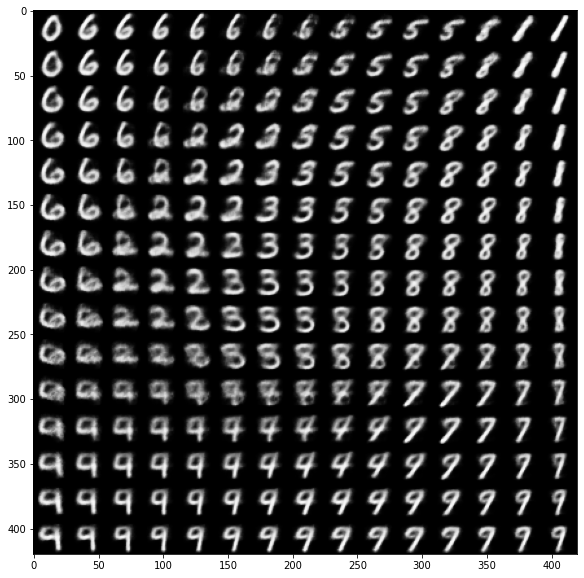

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()